In [6]:
import pandas
import os
import matplotlib.pyplot as plt
import re
from pathlib import Path
import json

In [3]:
result_dir = "eval-results"
result_naming = "{method}-F{frozen_layers}-T{task_layers}-aug{aug_size}-bf16{bf16}-merged_T{temp}_P{top_p}_evaluation.json"

In [41]:
speed = {'multi-task': {}, 'lora': {}}
def extract_numbers_from_txts(directory: Path):
    txt_files = directory.glob("*.txt")
    number_pattern = re.compile(r"Avg generation throughput:\s*([0-9]+(?:\.[0-9]+)?)\s+tokens/s")

    for txt_file in txt_files:
        text = txt_file.read_text(encoding="utf-8")
        numbers = number_pattern.findall(text)[:-1]
        average = sum(map(float, numbers)) / len(numbers) if numbers else 0
        print(f"{txt_file.name}: {average}")
        if 'mt' in txt_file.name:
            name = txt_file.name
            layers = int(name.split('vllm_mt_f')[1].split("_")[0])   
            speed['multi-task'][layers+2] = average
        else:
            name = txt_file.name
            layers = int(name.split('vllm_lora_f')[1].split("_")[0])   
            speed['lora'][layers] = average


if __name__ == "__main__":
    base_dir = Path("eval-results/inference-log")
    extract_numbers_from_txts(base_dir)

vllm_mt_f6_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 1742.3142857142857
vllm_mt_f14_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 1170.1899999999998
vllm_mt_f22_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 852.0
vllm_mt_f28_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 746.7234375
vllm_lora_f8_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 1766.2041666666667
vllm_lora_f16_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 1162.8461538461538
vllm_lora_f24_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 821.1129032258065
vllm_lora_f30_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 748.4760563380282


In [42]:
speed

{'multi-task': {8: 1742.3142857142857,
  16: 1170.1899999999998,
  24: 852.0,
  30: 746.7234375},
 'lora': {8: 1766.2041666666667,
  16: 1162.8461538461538,
  24: 821.1129032258065,
  30: 748.4760563380282}}

In [28]:
results = {}
results['multi-task'] = {}
for frozen_layers in [6, 14, 22, 28]:
    name = result_naming.format(
        method="leobitz_MultiTask",
        frozen_layers=frozen_layers,
        task_layers=2,
        aug_size=1.0,
        bf16=0,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    frozen_layers = frozen_layers + 2
    results['multi-task'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name:
            continue
        results['multi-task'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['multi-task'][frozen_layers]['average'] = sum(results['multi-task'][frozen_layers].values()) / len(results['multi-task'][frozen_layers])

results['lora'] = {}
for frozen_layers in [8, 16, 24, 30]:
    name = result_naming.format(
        method="leobitz_LoRA",
        frozen_layers=frozen_layers,
        task_layers=0,
        aug_size=1.0,
        bf16=1,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    results['lora'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name:
            continue
        results['lora'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['lora'][frozen_layers]['average'] = sum(results['lora'][frozen_layers].values()) / len(results['lora'][frozen_layers])

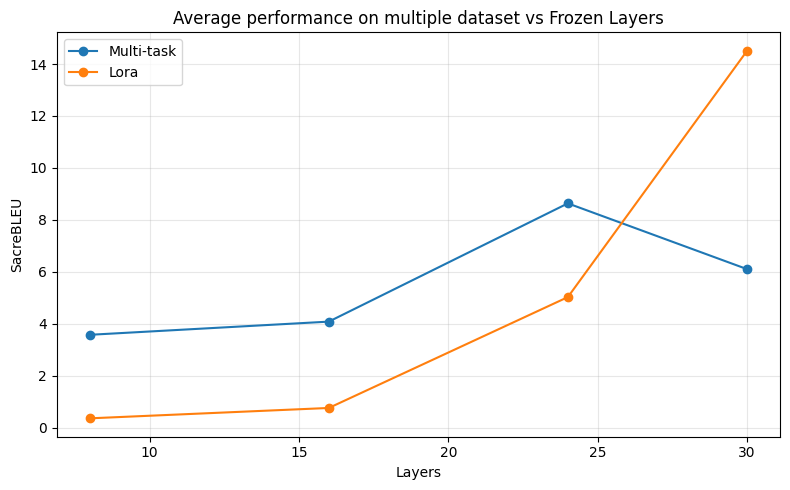

In [31]:
plt.figure(figsize=(8, 5))
for method in ("multi-task", "lora"):
    frozen_order = sorted(results[method])
    scores = [results[method][layers]['average'] for layers in frozen_order]
    plt.plot(frozen_order, scores, marker="o", label=method.capitalize())

plt.title(f"Average performance on multiple dataset vs Frozen Layers")
plt.xlabel("Layers")
plt.ylabel("SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

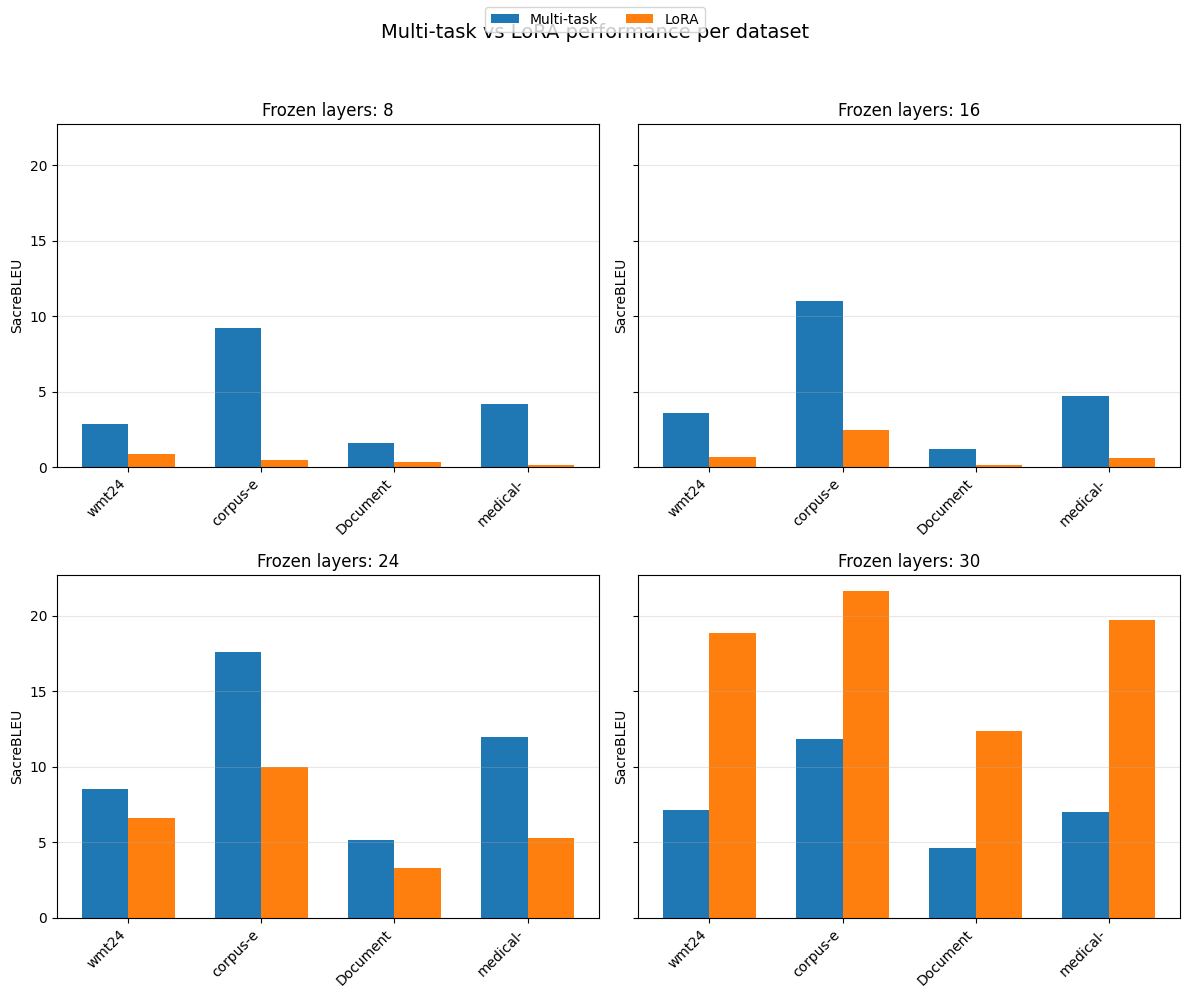

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

layers = sorted(results['multi-task'])
width = 0.35
legend_handles = None

for ax, layer in zip(axes, layers):
    datasets = [
        ds for ds in results['multi-task'][layer]
        if ds != 'average' and ds in results['lora'][layer] and ds != 'all'
    ]
    x = range(len(datasets))
    multi_scores = [results['multi-task'][layer][ds] for ds in datasets]
    lora_scores = [results['lora'][layer][ds] for ds in datasets]

    bars_multi = ax.bar([i - width / 2 for i in x], multi_scores, width=width, label="Multi-task")
    bars_lora = ax.bar([i + width / 2 for i in x], lora_scores, width=width, label="LoRA")

    if legend_handles is None:
        legend_handles = (bars_multi[0], bars_lora[0])

    ax.set_title(f"Frozen layers: {layer}")
    ax.set_xticks(list(x))
    ax.set_xticklabels([ds[:8] for ds in datasets], rotation=45, ha="right")
    ax.set_ylabel("SacreBLEU")
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(layers):]:
    ax.axis("off")

fig.suptitle("Multi-task vs LoRA performance per dataset", fontsize=14)
fig.legend(legend_handles, ["Multi-task", "LoRA"], loc="upper center", ncol=2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

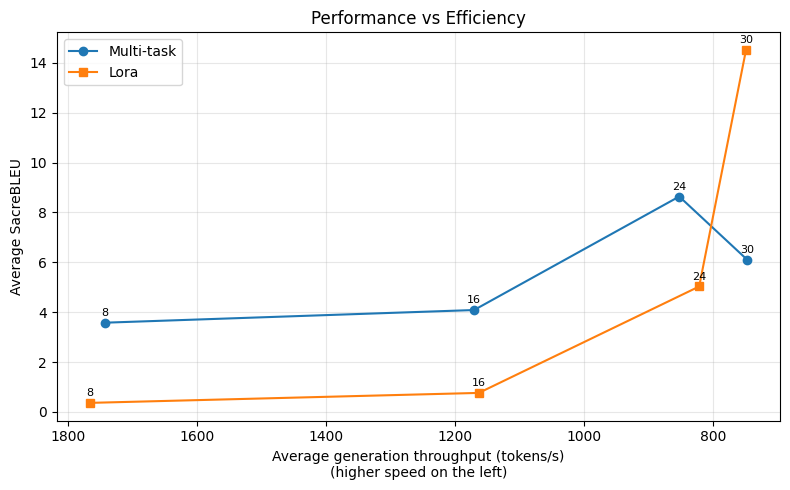

In [45]:
plt.figure(figsize=(8, 5))

styles = {"multi-task": {"color": "tab:blue", "marker": "o"},
          "lora": {"color": "tab:orange", "marker": "s"}}

for method, style in styles.items():
    layers = sorted(results[method])
    throughputs, averages_plot, layer_labels = [], [], []
    for layer in layers:
        if layer not in speed[method]:
            continue
        throughputs.append(speed[method][layer])
        averages_plot.append(results[method][layer]["average"])
        layer_labels.append(layer)

    plt.plot(throughputs, averages_plot, label=method.capitalize(),
             marker=style["marker"], color=style["color"])
    for t, s, layer in zip(throughputs, averages_plot, layer_labels):
        plt.annotate(f"{layer}", (t, s), textcoords="offset points",
                     xytext=(0, 5), ha="center", fontsize=8)

plt.gca().invert_xaxis()
plt.title("Performance vs Efficiency")
plt.xlabel("Average generation throughput (tokens/s)\n(higher speed on the left)")
plt.ylabel("Average SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
aug_results = results

In [48]:
results = {}
results['multi-task'] = {}
for frozen_layers in [6, 14, 22, 28]:
    name = result_naming.format(
        method="leobitz_MultiTask",
        frozen_layers=frozen_layers,
        task_layers=2,
        aug_size=0.0,
        bf16=0,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    frozen_layers = frozen_layers + 2
    results['multi-task'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name:
            continue
        results['multi-task'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['multi-task'][frozen_layers]['average'] = sum(results['multi-task'][frozen_layers].values()) / len(results['multi-task'][frozen_layers])

results['lora'] = {}
for frozen_layers in [8, 16, 24, 30]:
    name = result_naming.format(
        method="leobitz_LoRA",
        frozen_layers=frozen_layers,
        task_layers=0,
        aug_size=0.0,
        bf16=1,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    results['lora'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name:
            continue
        results['lora'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['lora'][frozen_layers]['average'] = sum(results['lora'][frozen_layers].values()) / len(results['lora'][frozen_layers])

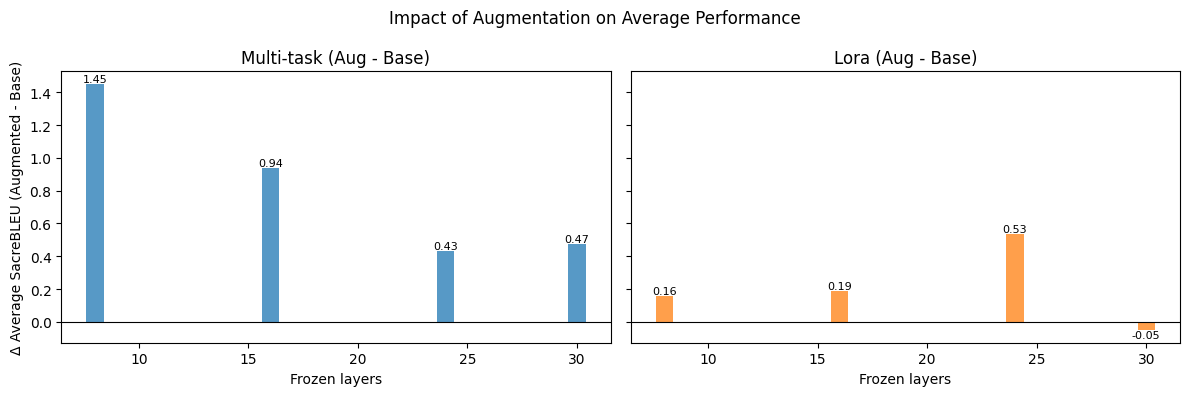

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, method, color in zip(
    axes, ["multi-task", "lora"], ["tab:blue", "tab:orange"]
):
    layers = sorted(results[method])
    method_result = results[method][layer]
    deltas = [
        aug_results[method][layer]["average"] - results[method][layer]["average"]
        for layer in layers
    ]

    bars = ax.bar(layers, deltas, color=color, alpha=0.75)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(f"{method.capitalize()} (Aug - Base)")
    ax.set_xlabel("Frozen layers")

    for bar, delta in zip(bars, deltas):
        y = bar.get_height()
        va = "bottom" if y >= 0 else "top"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y,
            f"{delta:.2f}",
            ha="center",
            va=va,
            fontsize=8,
            color="black",
        )

axes[0].set_ylabel("Δ Average SacreBLEU (Augmented - Base)")
fig.suptitle("Impact of Augmentation on Average Performance")
plt.tight_layout()
plt.show()

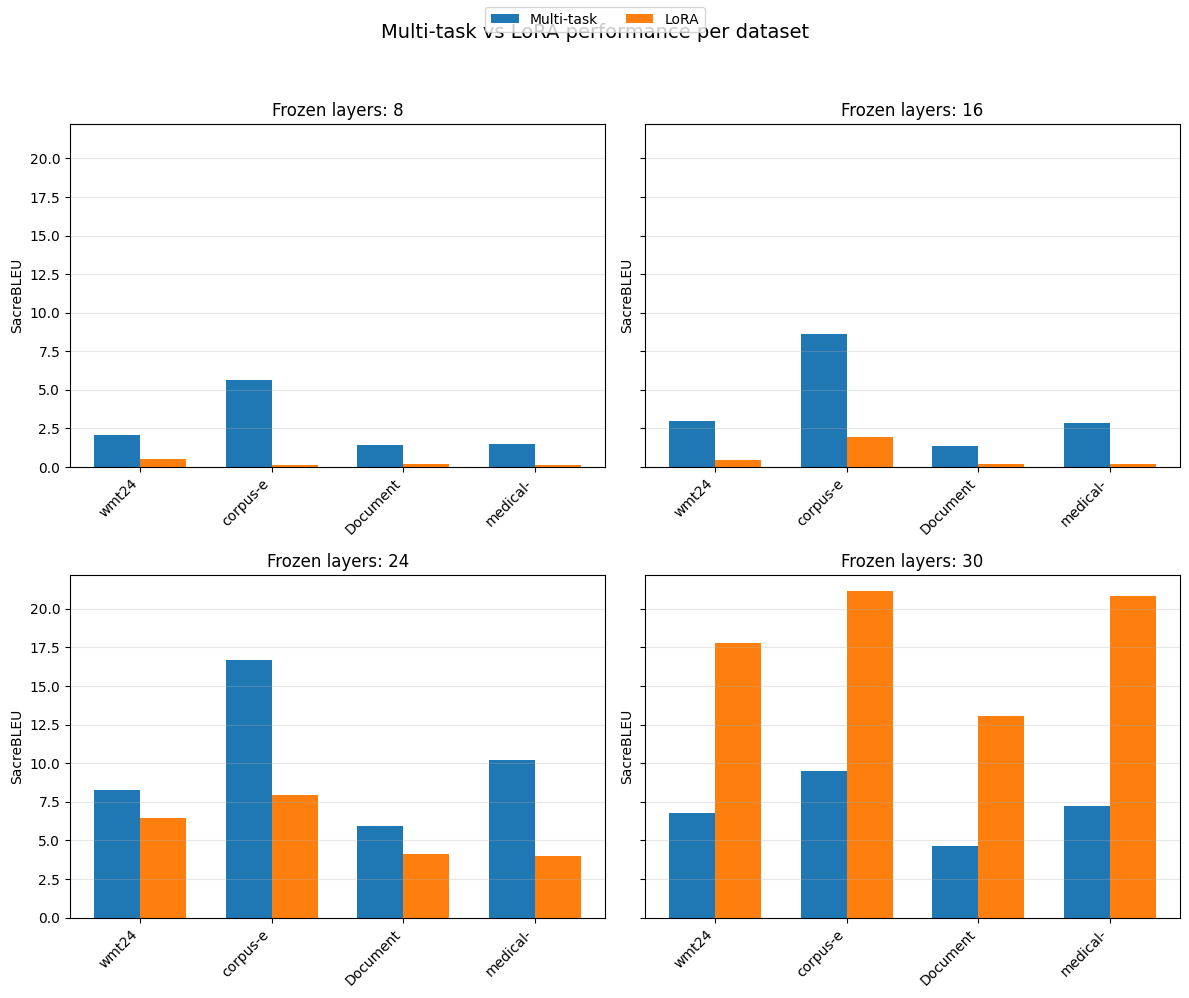

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

layers = sorted(results['multi-task'])
width = 0.35
legend_handles = None

for ax, layer in zip(axes, layers):
    datasets = [
        ds for ds in results['multi-task'][layer]
        if ds != 'average' and ds in results['lora'][layer] and ds != 'all'
    ]
    x = range(len(datasets))
    multi_scores = [results['multi-task'][layer][ds] for ds in datasets]
    lora_scores = [results['lora'][layer][ds] for ds in datasets]

    bars_multi = ax.bar([i - width / 2 for i in x], multi_scores, width=width, label="Multi-task")
    bars_lora = ax.bar([i + width / 2 for i in x], lora_scores, width=width, label="LoRA")

    if legend_handles is None:
        legend_handles = (bars_multi[0], bars_lora[0])

    ax.set_title(f"Frozen layers: {layer}")
    ax.set_xticks(list(x))
    ax.set_xticklabels([ds[:8] for ds in datasets], rotation=45, ha="right")
    ax.set_ylabel("SacreBLEU")
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(layers):]:
    ax.axis("off")

fig.suptitle("Multi-task vs LoRA performance per dataset", fontsize=14)
fig.legend(legend_handles, ["Multi-task", "LoRA"], loc="upper center", ncol=2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

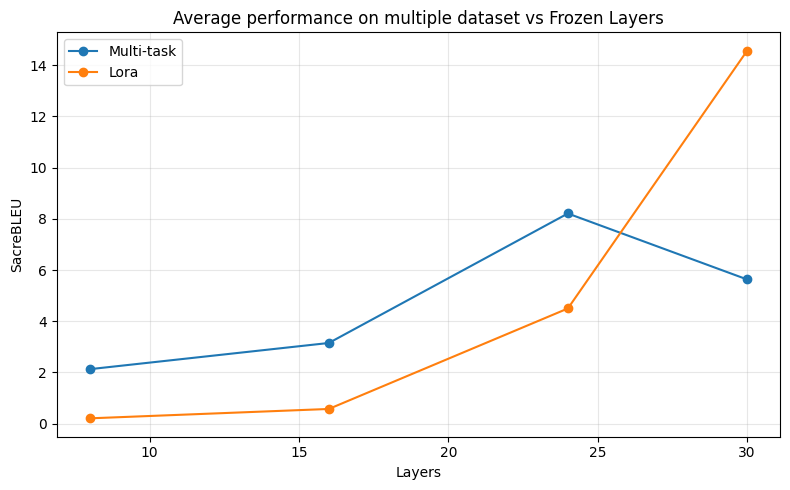

In [51]:
plt.figure(figsize=(8, 5))
for method in ("multi-task", "lora"):
    frozen_order = sorted(results[method])
    scores = [results[method][layers]['average'] for layers in frozen_order]
    plt.plot(frozen_order, scores, marker="o", label=method.capitalize())

plt.title(f"Average performance on multiple dataset vs Frozen Layers")
plt.xlabel("Layers")
plt.ylabel("SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

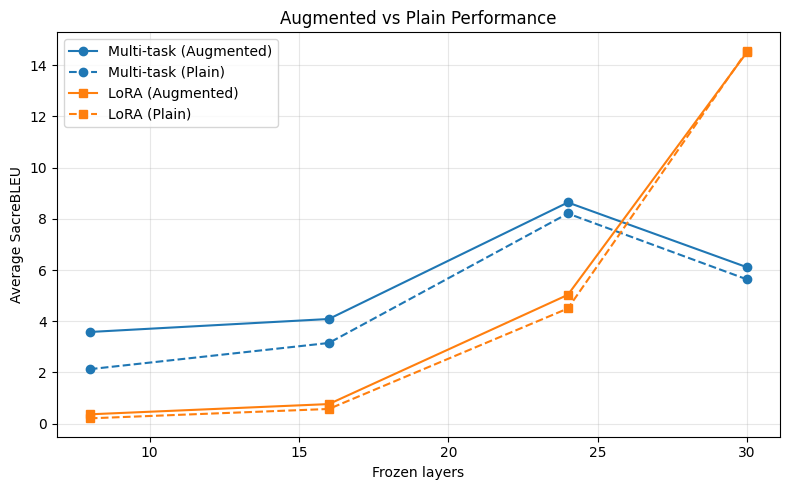

In [52]:
plt.figure(figsize=(8, 5))

layers_mt = sorted(results["multi-task"])
layers_lora = sorted(results["lora"])

plt.plot(
    layers_mt,
    [aug_results["multi-task"][layer]["average"] for layer in layers_mt],
    label="Multi-task (Augmented)",
    marker="o",
    linestyle="-",
    color="tab:blue",
)
plt.plot(
    layers_mt,
    [results["multi-task"][layer]["average"] for layer in layers_mt],
    label="Multi-task (Plain)",
    marker="o",
    linestyle="--",
    color="tab:blue",
)

plt.plot(
    layers_lora,
    [aug_results["lora"][layer]["average"] for layer in layers_lora],
    label="LoRA (Augmented)",
    marker="s",
    linestyle="-",
    color="tab:orange",
)
plt.plot(
    layers_lora,
    [results["lora"][layer]["average"] for layer in layers_lora],
    label="LoRA (Plain)",
    marker="s",
    linestyle="--",
    color="tab:orange",
)

plt.title("Augmented vs Plain Performance")
plt.xlabel("Frozen layers")
plt.ylabel("Average SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()